#Part 2 — Geodesic Quantization and Decoder Fine-Tuning

In the second stage, the focus shifted from continuous latents to a **discrete representation** that better respects the geometry of the data. This was achieved by clustering latent vectors using **geodesic distances** on a k-NN graph, followed by **fine-tuning the decoder** to reconstruct from these quantized codes.

##Step 1 — Preparing Latents
- Dataset: **50k CIFAR-10 images**.  
- Each image -> latent grid $4 \times 4 \times 64$ -> 16 tokens.  
- Flattened into **800k latent vectors** of size 64, standardized per channel.  

##Step 2 — Geodesic Codebook
- Built a **k-NN graph** on the latent set (~33M edges, 1 connected component).  
- Applied **Geodesic K-Medoids** with $K=128$, converging after 3 iterations.  
- Each medoid corresponds to a **real latent vector** from the data.  
- Every latent token was assigned to its **nearest medoid in geodesic space**, yielding discrete sequences of 16 indices per image.  

###Results (Quantization)
- **Codebook usage:** 128/128 codes (no collapse).  
- **Perplexity:** 103.47 (balanced code distribution).  
- **Quantization error (geodesic):** mean=7.93, median=7.88, p90=11.27, p99=14.03.  
- Prototypes and assignments saved for decoding and downstream tasks.  

##Step 3 — Decoder Fine-Tuning
To make the decoder work smoothly with quantized inputs, we **froze the encoder** and retrained only the decoder:

- **Input:** latent means μ, standardized and quantized to nearest prototypes.  
- **Training:** decoder reconstructs images from quantized latents, optimized with **MSE loss**.  
- **Optimizer:** Adam, trained for 100 epochs.  

###Results (Fine-Tuning)
- MSE reconstruction loss improved from **0.0201 -> 0.0160** over 100 epochs.  
- Final model saved as `vae_cifar10_finetuned_decoder.pth`.  

In [ ]:
#[Cell 10] Global imports & setup variables 

#Standard libraries
import json
from pathlib import Path

#Scientific stack
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

#Dataset & transformations
from torchvision import datasets, transforms

#Machine learning / neighbors / manifolds
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE

#Sparse graphs and algorithms
from scipy.sparse import coo_matrix, csr_matrix
from scipy.sparse.csgraph import connected_components, dijkstra

#Plotting
import matplotlib.pyplot as plt

#Custom modules
from vae import VAE
from geodesic_kmedoids import GeodesicKMedoids

#[Cell 0] Global setup 

#Paths
ROOT         = Path.cwd()
RESULTS_PATH = Path("results")
RESULTS_PATH = ROOT / "results"
MODELS_PATH  = ROOT / "models"
DATA_PATH    = ROOT / "data"
OUT_DIR      = RESULTS_PATH / "geodesic_quant"
MODEL_PATH   = RESULTS_PATH / "vae_cifar10.pth"

#Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Hyperparameters
#Training / fine-tuning
BATCH_SIZE = 256
EPOCHS     = 100
LR         = 5e-5
LATENT_DIM = 64

#k-NN graph
KNN_K   = 25       #number of neighbors
MUTUAL  = False    #keep only reciprocal edges
N_JOBS  = -1

#Geodesic k-Medoids
K_CODEBOOK        = 128
ITER_MAX          = 5
UPDATE_CANDIDATES = 5
SEED              = 42

#t-SNE
PERPLEXITY = 400
MAX_PLOT   = 30_000

#-
#Locate most recent latent file (if not already defined)
if 'LATENTS_PATH' not in globals():
    candidates = list(RESULTS_PATH.glob("training_latent_mus_*.npy"))
    assert len(candidates) > 0, (
        "No latent file found in results/. "
        "Run [Cell 7] from Week 1 first to save mu(x) in shape (N, H, W, D)."
    )
    LATENTS_PATH = max(candidates, key=lambda p: p.stat().st_mtime)

print("ROOT:", ROOT.resolve())
print("Latent file exists:", LATENTS_PATH.exists())
print("LATENTS_PATH:", LATENTS_PATH)


ROOT: C:\Users\lucam\Documents\Uni\Deep\vqvae_geodesic_project
Latent file exists: True
LATENTS_PATH: c:\Users\lucam\Documents\Uni\Deep\vqvae_geodesic_project\results\training_latent_mus_27_08_2025.npy


### [Cell 11] Loading Latents into Z (from Week 1)

This cell loads and reshapes the **continuous latent means** ($\mu$) produced by the VAE in Week 1, preparing them for geodesic quantization.  

* **Data source:** latent files (`training_latent_mus_*.npy`) saved from the trained encoder on CIFAR-10.  
* **Original shape:**  
  $$
  Z_{\text{full}} \in \mathbb{R}^{N \times H \times W \times D}, \quad (50000, 4, 4, 64)
  $$
  Each image → a $4 \times 4$ latent map = 16 tokens of 64 dimensions each.  
* **Reshape for clustering:**  
  Flatten to  
  $$
  Z \in \mathbb{R}^{N_{\text{flat}} \times D}, \quad N_{\text{flat}} = 50k \times 16 = 800k
  $$
  so every token is treated as a point in $\mathbb{R}^{64}$.  
* **Format:** converted to `float32` for efficiency.  

This flattened latent set $Z$ becomes the input for the **k-NN graph** and **geodesic K-Medoids clustering** in Part 2, enabling a discrete codebook aligned with the latent geometry.  


In [ ]:
#[Cell 11] Loading latents into Z (from Week 1) 

if not LATENTS_PATH.exists():
    raise FileNotFoundError(
        f"Latent file not found: {LATENTS_PATH}. "
        "Run Cell 7 from Week 1 first to save mu(x) in format (N, H, W, D)."
    )

Z_full = np.load(LATENTS_PATH, mmap_mode=None)  #expected: (N, H, W, D)
if Z_full.dtype != np.float32:
    Z_full = Z_full.astype(np.float32, copy=False)

if Z_full.ndim == 4:
    N, H, W, D = Z_full.shape
    L = H * W
    Z = Z_full.reshape(N * L, D)  #flatten positions
    N_flat = Z.shape[0]
    print(f"Latents: {N} images, grid {H}x{W} ({L} positions) with D={D}")
    print(f"Z reshaped for clustering: {Z.shape}, N_flat={N_flat}, dtype: {Z.dtype}")
elif Z_full.ndim == 2:
    #fallback for old case (N, D)
    N, D = Z_full.shape
    L = 1
    Z = Z_full
    N_flat = Z.shape[0]
    print(f"Latents in old format: {Z.shape}, N_flat={N_flat}, dtype: {Z.dtype}")
else:
    raise ValueError(f"Unrecognized latent shape: {Z_full.shape}")


Latenti: 50000 immagini, griglia 4x4 (16 posizioni) con D=64
Z rimodellato per clustering: (800000, 64), N_flat=800000, dtype: float32


### [Cell 12] k-NN Graph Construction

This cell builds the **k-Nearest Neighbors (k-NN) graph** on the latent vectors $Z$ to approximate the latent manifold’s geometry for geodesic distances.  

* **Input:** flattened latents  
  $$
  Z \in \mathbb{R}^{N_{\text{flat}} \times D}, \quad (800k, 64)
  $$
  each row = one latent token.  
* **Method:**  
  * Use `NearestNeighbors` to find $K=25$ neighbors per point.  
  * Remove self-edges, keep distances as edge weights.  
  * Build a sparse adjacency matrix (COO → CSR), then symmetrize:  
    $$
    G = A + A^\top
    $$  
  where $A$ is the initial neighbor matrix.  
* **Output:** sparse graph $G \in \mathbb{R}^{N_{\text{flat}} \times N_{\text{flat}}}$ with $\sim$0.01% density.  

This graph captures **local topology** of the latent space and is the basis for computing **geodesic distances** and running **K-Medoids clustering** in the next step.  


In [ ]:
#[Cell 12] k-NN graph (scikit-learn + scipy sparse) 

#Nearest neighbors
nn = NearestNeighbors(n_neighbors=KNN_K + 1, algorithm="auto", n_jobs=N_JOBS)  #+1 include il punto stesso
nn.fit(Z)
dists, idxs = nn.kneighbors(Z, return_distance=True)  #dists: (N_flat, K+1) float64, idxs: int64

#Rimuovi self-edge (distanza 0)
dists = dists[:, 1:]
idxs  = idxs[:, 1:]

#Indici righe/colonne per COO
rows = np.repeat(np.arange(N_flat, dtype=np.int64), KNN_K)
cols = idxs.ravel()  #già int64

# PESI in float32 per dimezzare memoria
wts = dists.astype(np.float32, copy=False).ravel()

#Grafo diretto in COO float32
G = coo_matrix((wts, (rows, cols)), shape=(N_flat, N_flat), dtype=np.float32)

#Libera buffer grandi non più necessari
del dists, idxs, wts

#Simmetrizzazione (non direzionale)
if MUTUAL:
    #Tieni solo archi reciproci (peso = min tra i due versi)
    A  = G.tocsr()
    AT = G.T.tocsr()
    G_undirected = A.minimum(AT)
else:
    #Somma con il trasposto (stesso comportamento della tua versione originale)
    G_undirected = (G + G.T).tocsr()

#Assicuriamoci che il dtype resti float32
G = G_undirected.astype(np.float32, copy=False)

#Cleanup oggetti temporanei
nn = None
del G_undirected

print(G)
print("dtype:", G.dtype)
print("Sparsity:", 1.0 - G.nnz / float(N_flat * N_flat))


  (0, 57536)	2.0868072509765625
  (0, 63376)	1.6816518306732178
  (0, 65120)	2.167046070098877
  (0, 107728)	2.9324042797088623
  (0, 108992)	1.5381951332092285
  (0, 119968)	2.0861735343933105
  (0, 130032)	1.5528990030288696
  (0, 130080)	1.3289872407913208
  (0, 148640)	1.8439956903457642
  (0, 172304)	1.3410009145736694
  (0, 208176)	2.882004976272583
  (0, 237520)	2.397092342376709
  (0, 241296)	1.6126458644866943
  (0, 246784)	2.5598928928375244
  (0, 247776)	2.7790582180023193
  (0, 250672)	2.3284671306610107
  (0, 256992)	1.6935967206954956
  (0, 261696)	1.4915344715118408
  (0, 264832)	3.0131471157073975
  (0, 273760)	1.4034252166748047
  (0, 338928)	1.651242733001709
  (0, 349520)	1.479861855506897
  (0, 371200)	2.916041374206543
  (0, 420160)	2.312537670135498
  (0, 438320)	1.5453044176101685
  :	:
  (799999, 163439)	5.276270389556885
  (799999, 187055)	4.36485481262207
  (799999, 216479)	7.995858669281006
  (799999, 227951)	4.3203125
  (799999, 244639)	5.908143043518066
  (

### [Cell 13] Largest Connected Component (LCC)

After building the k-NN graph, this cell isolates the **Largest Connected Component (LCC)** to ensure geodesic distances are well-defined.  

* **Input:** sparse k-NN graph $G \in \mathbb{R}^{N_{\text{flat}} \times N_{\text{flat}}}$.  
* **Method:** use  
  $$
  n_{\text{comp}}, \; labels = \texttt{connected\_components}(G)
  $$
  to detect connected components. If $n_{\text{comp}}>1$, keep only the largest one (mask + index map).  
* **Output:**  
  * reduced graph $G_{\text{LCC}}$, always connected,  
  * filtered latents $Z_{\text{LCC}}$,  
  * metadata files (`lcc_idx_map.npy`, `geoq_summary.json`).  

**Why it matters:** clustering with **geodesic K-Medoids** relies on shortest paths (Dijkstra), which require a connected graph. Focusing on the LCC avoids infinite distances and filters out unstable tokens, ensuring clean latent sequences for later autoregressive modeling.  


In [ ]:
#[Cell 13] Largest Connected Component (LCC) 

from scipy.sparse.csgraph import connected_components
import json

n_comp, labels = connected_components(G, directed=False)
print(f"Connected components: {n_comp}")

if n_comp > 1:
    #take the largest component
    unique, counts = np.unique(labels, return_counts=True)
    lcc_label = unique[np.argmax(counts)]
    mask = (labels == lcc_label)
    idx_map = np.where(mask)[0]
    print(f"LCC size: {mask.sum()} / {N_flat} ({mask.sum()/N_flat:.1%})")
    
    #Induce G on the LCC
    G = G[mask][:, mask].tocsr()
    Z_lcc = Z[idx_map]
else:
    idx_map = np.arange(N_flat)
    Z_lcc = Z

N_LCC = G.shape[0]
print("Graph on LCC:", G.shape, "nnz:", G.nnz)

#mapping: LCC indices -> original flattened indices (0..N_flat-1)
np.save(OUT_DIR / "lcc_idx_map.npy", idx_map)

#metadata summary (original shapes and LCC/flatten dimensions)
meta = dict(
    N_images=int(N),
    H=int(H),
    W=int(W),
    D=int(D),
    N_flat=int(N_flat),
    N_LCC=int(N_LCC),
)
with open(OUT_DIR / "geoq_summary.json", "w") as f:
    json.dump(meta, f, indent=2)


Connected components: 1
Graph on LCC: (800000, 800000) nnz: 32949126


### [Cell 14] Geodesic Distances (Dijkstra utility)
Defines `geodesic_distances_from_sources`:  
given a sparse k-NN graph $G$ and a set of sources, computes  
$$
D_{s,\cdot} = \text{Dijkstra}(G, s)
$$  
for each source $s$. Output is a matrix of geodesic distances used by **K-Medoids** to assign points to clusters.


In [ ]:
#[Cell 14] Utility: Multi-source Dijkstra (loop over medoids) 

from scipy.sparse.csgraph import dijkstra

def geodesic_distances_from_sources(G_csr: csr_matrix, sources: np.ndarray) -> np.ndarray:
    """
    Returns a matrix D of shape (len(sources), N_nodes) with the geodesic distances
    from each source to all nodes. Uses Dijkstra on a weighted undirected graph.
    """
    D_list = []
    for s in sources:
        d = dijkstra(csgraph=G_csr, directed=False, indices=s, return_predecessors=False)
        D_list.append(d)
    return np.vstack(D_list)  #(S, N)


### [Cell 15] Fit Geodesic K-Medoids
Runs **K-Medoids clustering** on the latent vectors in the LCC using geodesic distances.  
* **Params:** $K_{\text{codebook}}=128$, $\text{ITER\_MAX}=5$, $\text{SEED}=42$.  
* Produces:  
  * medoid indices (`geoq_medoids_idx.npy`),  
  * assignments (`geoq_assignments.npy`, `geoq_assignments_all.npy`),  
  * distances to medoids (`geoq_dist_to_medoid.npy`),  
  * prototypes = actual medoid vectors (`geoq_prototypes.npy`).  
This step converts the **continuous latent space** into a **discrete codebook**.


In [ ]:
#[Cell 15] Fit geodesic quantizer and save artifacts 

geoq = GeodesicKMedoids(G_csr=G, Z_ref=Z_lcc, 
                        k=K_CODEBOOK, iter_max=ITER_MAX,
                        update_candidates=UPDATE_CANDIDATES,
                        random_state=SEED).fit()

#Save artifacts (relative to the LCC!)
OUT_DIR = RESULTS_PATH / "geodesic_quant"
OUT_DIR.mkdir(parents=True, exist_ok=True)

np.save(OUT_DIR / "geoq_medoids_idx.npy", geoq.medoid_idx_)
np.save(OUT_DIR / "geoq_assignments.npy", geoq.assign_)
np.save(OUT_DIR / "geoq_dist_to_medoid.npy", geoq.dist_to_medoid_)

#NEW: assignments for all N_flat points (LCC + outside LCC) 
assign_all = -np.ones(N_flat, dtype=int)
assign_all[idx_map] = geoq.assign_
np.save(OUT_DIR / "geoq_assignments_all.npy", assign_all)

#NEW: continuous prototypes (medoids as vectors in Z_lcc) 
prototypes = Z_lcc[geoq.medoid_idx_]   #(K_CODEBOOK, D)
np.save(OUT_DIR / "geoq_prototypes.npy", prototypes)

print("-> Saved medoids, assignments, distances, assignments_all and prototypes in:", OUT_DIR.resolve())
print("   geoq_medoids_idx.npy        :", geoq.medoid_idx_.shape)
print("   geoq_assignments.npy        :", geoq.assign_.shape)
print("   geoq_dist_to_medoid.npy     :", geoq.dist_to_medoid_.shape)
print("   geoq_assignments_all.npy    :", assign_all.shape, 
      "| filled:", int((assign_all != -1).sum()), "/", int(N_flat))
print("   geoq_prototypes.npy         :", prototypes.shape)


[Geodesic K-Medoids] iter 1/5 | cost=6,405,371.59
[Geodesic K-Medoids] iter 2/5 | cost=6,345,814.45
[Geodesic K-Medoids] iter 3/5 | cost=6,340,428.32
Convergenza: medoid invariati.
→ Salvati medoids, assignments, distanze, assignments_all e prototypes in: C:\Users\lucam\Documents\Uni\Deep\vqvae_geodesic_project\results\geodesic_quant
   geoq_medoids_idx.npy        : (128,)
   geoq_assignments.npy        : (800000,)
   geoq_dist_to_medoid.npy     : (800000,)
   geoq_assignments_all.npy    : (800000,) | filled: 800000 / 800000
   geoq_prototypes.npy         : (128, 64)


### [Cell 16] Stats & Perplexity
Evaluates the quality of the codebook.  
* **Quantization error:** mean, median, p90, p99 of geodesic distances to medoids (e.g. mean ≈ 7.93).  
* **Perplexity:**  
  $$
  \text{Perplexity} = \exp\!\Big(-\sum_i p_i \log p_i\Big)
  $$
  where $p_i$ is code usage. High perplexity → uniform usage, no collapse.  
In this run: **128/128 codes used**, perplexity ≈ 103.5 → excellent utilization.  

In [ ]:
#[Cell 16] Stats & Perplexity 

dist = geoq.dist_to_medoid_
assign = geoq.assign_

#Geodesic quantization error
q_mean = float(np.mean(dist))
q_med  = float(np.median(dist))
q_p90  = float(np.quantile(dist, 0.90))
q_p99  = float(np.quantile(dist, 0.99))
print(f"Quantization (geodesic) — mean={q_mean:.4f}, median={q_med:.4f}, p90={q_p90:.4f}, p99={q_p99:.4f}")

#Codebook perplexity
counts = np.bincount(assign, minlength=K_CODEBOOK).astype(np.float64)
p = counts / counts.sum()
mask = p > 0
H = -np.sum(p[mask] * np.log(p[mask]))
perplexity = float(np.exp(H))
print(f"Codebook usage: {int((p>0).sum())}/{K_CODEBOOK} codes used | Perplexity={perplexity:.2f}")

#Save metrics
with open(OUT_DIR / "geoq_metrics.txt", "w") as f:
    f.write(f"quant_geodesic_mean={q_mean:.6f}\n")
    f.write(f"quant_geodesic_median={q_med:.6f}\n")
    f.write(f"quant_geodesic_p90={q_p90:.6f}\n")
    f.write(f"quant_geodesic_p99={q_p99:.6f}\n")
    f.write(f"codes_used={int((p>0).sum())}\n")
    f.write(f"perplexity={perplexity:.6f}\n")


Quantization (geodesic) — mean=7.9255, median=7.8814, p90=11.2684, p99=14.0348
Codebook usage: 128/128 codes used | Perplexity=103.47


# t-SNE Visualization of Latents (LCC)

This cell projects the **latent vectors in the LCC** into 2D with **t-SNE**, coloring points by their assigned **discrete code**. It provides a qualitative check of how well clusters from geodesic K-Medoids are separated.  

* **Input:**  
  * $Z_{\text{LCC}} \in \mathbb{R}^{N \times 64}$ → continuous latents.  
  * Cluster assignments $y \in \{1,\dots,K\}$ from geodesic quantization.  

* **Method:**  
  1. Randomly subsample up to 30k points.  
  2. Standardize features (zero mean, unit variance).  
  3. Run t-SNE with perplexity ≈ 400, early exaggeration = 2.0, init = PCA.  
  4. Scatter plot in 2D, points colored by cluster ID.  

* **Output:** A 2D scatterplot where colors = codebook entries. Well-separated color regions indicate that the **discrete codebook is meaningful** and respects latent geometry.  


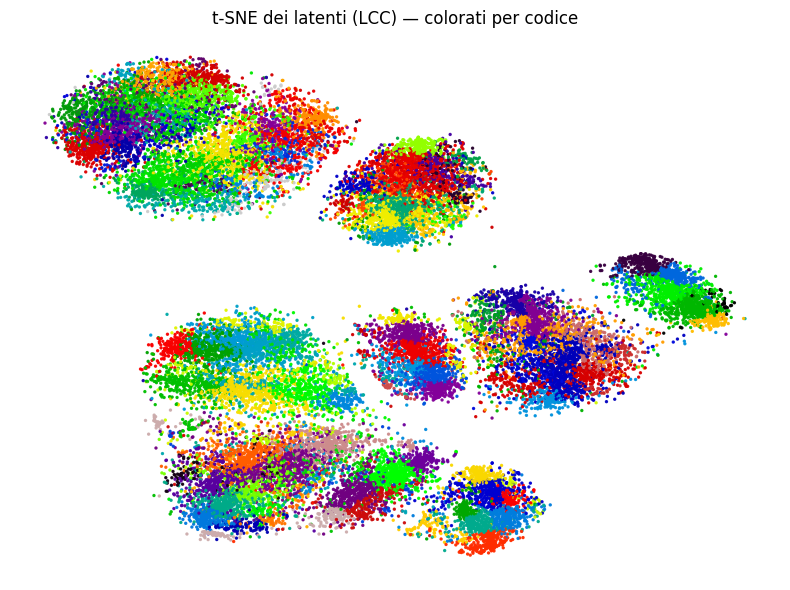

In [ ]:
#[Cell 17] t-SNE of latents (LCC) colored by code — simple version 

#1) Subsample
rng = np.random.default_rng(SEED)
M = min(MAX_PLOT, Z_lcc.shape[0])
sel = np.sort(rng.choice(Z_lcc.shape[0], size=M, replace=False))

Z = np.asarray(Z_lcc[sel], dtype=np.float32)   #(M, D)
y = geoq.assign_[sel]

#2) Standardize (feature-wise)
Z = (Z - Z.mean(0, keepdims=True)) / (Z.std(0, keepdims=True) + 1e-6)

#3) t-SNE
tsne = TSNE(n_components=2, init="pca",
            perplexity=PERPLEXITY, early_exaggeration=2.0,
            learning_rate="auto", random_state=SEED)
Z2 = tsne.fit_transform(Z)

#4) Plot
plt.figure(figsize=(8, 6))
plt.scatter(Z2[:, 0], Z2[:, 1], c=y, s=2, alpha=0.9, cmap="nipy_spectral")
plt.title("t-SNE of latents (LCC) — colored by code")
plt.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
#[Cell 18] Quantization of new z (NN -> code id) 

import numpy as np
from sklearn.neighbors import NearestNeighbors

#Build a NN index on the LCC for fast assignments
nn_all = NearestNeighbors(n_neighbors=1, algorithm="auto").fit(np.asarray(Z_lcc))

def quantize_new_latents(z_new: np.ndarray,
                         Z_lcc_ref: np.ndarray,
                         assign_lcc: np.ndarray,
                         nn_index: NearestNeighbors) -> np.ndarray:
    """
    Assigns each z_new the code of its nearest neighbor (Euclidean) in the LCC.
    z_new: (M, D)
    returns: codes_new (M,)
    """
    d, idx = nn_index.kneighbors(z_new, return_distance=True)
    codes = assign_lcc[idx.ravel()]
    return codes

def quantize_grid(mu_map_hw_last: np.ndarray,
                  nn_index: NearestNeighbors,
                  assign_lcc: np.ndarray):
    """
    Wrapper for latent maps.
    - mu_map_hw_last: (H, W, D) or (D, H, W)
    - Returns: code grid (H, W)

    Note: if the last axis is not D (latent dimension), rotate from (D, H, W) -> (H, W, D).
    """
    #If it comes as (D, H, W), convert to (H, W, D) by comparing with D of Z_lcc
    if mu_map_hw_last.ndim == 3 and mu_map_hw_last.shape[-1] != Z_lcc.shape[1]:
        mu_map_hw_last = np.moveaxis(mu_map_hw_last, 0, -1)  #(D,H,W) -> (H,W,D)

    H, W, D_ = mu_map_hw_last.shape
    z_new = mu_map_hw_last.reshape(H * W, D_)
    d, idx = nn_index.kneighbors(z_new, return_distance=True)
    #use the LCC assignments to map the neighbor index to the code
    codes = assign_lcc[idx.ravel()].reshape(H, W)
    return codes


### [Cell 19] CIFAR-10 Loader (train only): loads the CIFAR-10 training set with `ToTensor()`, builds a DataLoader for batches used in fine-tuning.  


In [ ]:
#[Cell 19]

#CIFAR10 loader (solo train)
transform = transforms.ToTensor()
train_loader = DataLoader(
    datasets.CIFAR10(root="data", train=True, download=True, transform=transform),
    batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True
)


Files already downloaded and verified



### [Cell 20] Load VAE & Freeze Encoder: loads the pre-trained VAE; the encoder is frozen (`requires_grad=False`), while the decoder remains trainable. The codebook prototypes (medoids) from geodesic clustering are also loaded.  



In [ ]:
#[Cell 20] Load VAE and freeze the encoder

vae = VAE(latent_dim=LATENT_DIM).to(device)
vae.load_state_dict(torch.load(MODEL_PATH, map_location=device))
vae.encoder.requires_grad_(False)   #frozen encoder
vae.decoder.requires_grad_(True)    #only decoder is trainable
vae.train()

#Load the codebook (medoid prototypes)
prototypes = np.load(OUT_DIR / "geoq_prototypes.npy")  #(K, D)
prototypes = torch.tensor(prototypes, dtype=torch.float32, device=device)

#Load NN index for fast assignment
assign_lcc = np.load(OUT_DIR / "geoq_assignments_all.npy")
Z_lcc = np.load(OUT_DIR / "lcc_idx_map.npy")  #optional, if needed



### [Cell 21] Quantization Helper: defines `quantize`, which  
  $$
  z \;\mapsto\; \hat{z} = \arg\min_{c \in \text{codebook}} \| \tfrac{z-\mu}{\sigma} - c \|_2
  $$
  Standardizes latent means, finds the closest prototype, and returns quantized vectors as decoder input.  


In [ ]:
#[Cell 21] Quantization helper (with standardized μ)

#Load standardization stats (from Part 1)
stats = np.load(OUT_DIR / "geoq_standardization_stats.npz")
mu_train    = torch.from_numpy(stats["mu"].astype(np.float32)).to(device)    #(D,)
sigma_train = torch.from_numpy(stats["sigma"].astype(np.float32)).to(device) #(D,)

#NN index on prototypes (std)
nn = NearestNeighbors(n_neighbors=1).fit(prototypes.cpu().numpy())

def quantize(mu_batch):
    #mu_batch: (B,D,H,W)
    B, D, H, W = mu_batch.shape
    mu_hwD = mu_batch.permute(0,2,3,1)  #(B,H,W,D)
    mu_std = (mu_hwD - mu_train.view(1,1,1,-1)) / (sigma_train.view(1,1,1,-1) + 1e-6)
    flat = mu_std.reshape(-1, D).cpu().numpy()
    _, idx = nn.kneighbors(flat, return_distance=True)
    codes = idx.ravel()
    zq = prototypes[codes].view(B, H, W, D).permute(0,3,1,2).contiguous()
    return zq



### [Cell 22] Fine-tuning Loop:  
  1. Encode images with frozen encoder → latent $\mu$.  
  2. Quantize with `quantize`.  
  3. Decode quantized vectors → reconstruction $\hat{x}$.  
  4. Optimize decoder weights using MSE loss:  
     $$
     \mathcal{L}_{rec} = \| x - \hat{x} \|_2^2
     $$  

In [ ]:
#[Cell 22] Fine-tuning loop
opt = torch.optim.Adam(vae.decoder.parameters(), lr=LR)

for epoch in range(1, EPOCHS+1):
    tot_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        with torch.no_grad():
            mu, _ = vae.encoder(x)
        zq = quantize(mu)                 #μ -> prototypes (std)
        recon = vae.decoder(zq)
        loss = F.mse_loss(recon, x)

        opt.zero_grad()
        loss.backward()
        opt.step()
        tot_loss += loss.item() * x.size(0)
    print(f"[{epoch}/{EPOCHS}] MSE recon: {tot_loss/len(train_loader.dataset):.4f}")

#Save updated decoder
torch.save(vae.state_dict(), RESULTS_PATH / "vae_cifar10_finetuned_decoder.pth")
print(" Fine-tuned decoder saved (standardized μ).")


[1/100] MSE recon: 0.0201
[2/100] MSE recon: 0.0182
[3/100] MSE recon: 0.0179
[4/100] MSE recon: 0.0177
[5/100] MSE recon: 0.0176
[6/100] MSE recon: 0.0175
[7/100] MSE recon: 0.0174
[8/100] MSE recon: 0.0174
[9/100] MSE recon: 0.0173
[10/100] MSE recon: 0.0173
[11/100] MSE recon: 0.0173
[12/100] MSE recon: 0.0172
[13/100] MSE recon: 0.0172
[14/100] MSE recon: 0.0172
[15/100] MSE recon: 0.0171
[16/100] MSE recon: 0.0171
[17/100] MSE recon: 0.0171
[18/100] MSE recon: 0.0171
[19/100] MSE recon: 0.0170
[20/100] MSE recon: 0.0170
[21/100] MSE recon: 0.0170
[22/100] MSE recon: 0.0170
[23/100] MSE recon: 0.0170
[24/100] MSE recon: 0.0170
[25/100] MSE recon: 0.0169
[26/100] MSE recon: 0.0169
[27/100] MSE recon: 0.0169
[28/100] MSE recon: 0.0169
[29/100] MSE recon: 0.0169
[30/100] MSE recon: 0.0169
[31/100] MSE recon: 0.0168
[32/100] MSE recon: 0.0168
[33/100] MSE recon: 0.0168
[34/100] MSE recon: 0.0168
[35/100] MSE recon: 0.0168
[36/100] MSE recon: 0.0168
[37/100] MSE recon: 0.0168
[38/100] M

### References

- **Kingma, D. P., & Welling, M.** (2014). *Auto-Encoding Variational Bayes*. arXiv:1312.6114.  
  [Foundational paper introducing Variational Autoencoders (VAE), basis for the latent space used in Part 2.]

- **Oord, A. v. d., Vinyals, O., & Kavukcuoglu, K.** (2017). *Neural Discrete Representation Learning*. In NeurIPS.  
  [Original VQ-VAE paper introducing discrete latent representations and codebooks.]

- **Arvanitidis, G., Hansen, L. K., & Hauberg, S.** (2018). *Latent Space Oddity: On the Curvature of Deep Generative Models*. In ICLR.  
  [Explores Riemannian geometry in latent spaces and motivates geodesic distances.]

- **Fumero, et al.** (2024). *Clustering on Latent Manifolds (Geodesic Distances)*.  
  [Reference highlighting the role of geodesic-based clustering in latent manifolds.]

- **Tenenbaum, J. B., de Silva, V., & Langford, J. C.** (2000). *A Global Geometric Framework for Nonlinear Dimensionality Reduction (Isomap)*. In Science, 290(5500), 2319–2323.  
  [Introduces the Isomap algorithm for approximating geodesic distances via k-NN graphs.]
